In [3]:
import pandas as pd
import numpy as np
import keras_contrib
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import LSTM, Dense, TimeDistributed, Embedding, Bidirectional
from keras.models import Model, Input
from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint
import csv
import warnings
warnings.filterwarnings("ignore")
import random
random.seed(10)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import f1_score
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
from keras.preprocessing.text import text_to_word_sequence

Using TensorFlow backend.


In [4]:
tsvfile=open("BC5DR-disease-IOB/train.tsv",encoding="utf-8")
tsvreader = csv.reader(tsvfile, delimiter="\t")
data=[]
sentences=[]
words=[]
tags=[]
maxsentlen=0
for line in tsvreader:
    if line!=[]:
        data.append(line)
        if line[0] not in words:
            words.append(line[0])
        if line[1] not in tags:
            tags.append(line[1])
    else:
        sentences.append(data)
        if len(data)>maxsentlen:
            maxsentlen=len(data)
        data=[]

In [5]:
print(len(sentences))
print(len(words))

4560
9980


In [6]:
word_to_index = {w : i + 2 for i, w in enumerate(words)}
print(word_to_index[words[0]])
word_to_index["UNK"] = 1
word_to_index["PAD"] = 0

# Dictionary lable:index pair
# label is key and value is index.
tag_to_index = {t : i + 1 for i, t in enumerate(tags)}
print(tag_to_index[tags[0]])

tag_to_index["PAD"] = 0

idx2word = {i: w for w, i in word_to_index.items()}
print(idx2word[2])
idx2tag = {i: w for w, i in tag_to_index.items()}
print(len(tag_to_index))

2
1
Selegiline
4


In [8]:
# Number of data points passed in each iteration
batch_size =50
# Passes through entire dataset
epochs = 20
# Maximum length of review
max_len = maxsentlen+15
# Dimension of embedding vector
embedding = 200

In [9]:
X = [[word_to_index[w[0]] for w in s] for s in sentences]
print(X[0],X[1])
count=0
for s in sentences:
    print(s)
    count=count+1
    if count>5:
        break
# Padding each sequence to have same length  of each word
X = pad_sequences(maxlen = max_len, sequences = X, padding = "post", value = word_to_index["PAD"])

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22] [23, 12, 24, 25, 26, 8, 9, 10, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 7, 38, 39, 8, 9, 10, 11, 30, 40, 32, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 3, 51, 52, 39, 53, 54, 50, 3, 51, 55, 22]
[['Selegiline', 'O'], ['-', 'O'], ['induced', 'O'], ['postural', 'B-Disease'], ['hypotension', 'I-Disease'], ['in', 'O'], ['Parkinson', 'B-Disease'], ["'", 'I-Disease'], ['s', 'I-Disease'], ['disease', 'I-Disease'], [':', 'O'], ['a', 'O'], ['longitudinal', 'O'], ['study', 'O'], ['on', 'O'], ['the', 'O'], ['effects', 'O'], ['of', 'O'], ['drug', 'O'], ['withdrawal', 'O'], ['.', 'O']]
[['OBJECTIVES', 'O'], [':', 'O'], ['The', 'O'], ['United', 'O'], ['Kingdom', 'O'], ['Parkinson', 'B-Disease'], ["'", 'I-Disease'], ['s', 'I-Disease'], ['Disease', 'I-Disease'], ['Research', 'O'], ['Group', 'O'], ['(', 'O'], ['UKPDRG', 'O'], [')', 'O'], ['trial', 'O'], ['found', 'O'], ['an', 'O'], ['increased', 'O'], ['mortality', 'O'], ['in',

In [10]:
print(X[0])
len(X[0])

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0]


169

In [11]:
# Convert label to index
y = [[tag_to_index[w[1]] for w in s] for s in sentences]
print(y[0])
# padding
y = pad_sequences(maxlen = max_len, sequences = y, padding = "post", value = tag_to_index["PAD"])

[1, 1, 1, 2, 3, 1, 2, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [12]:
num_tag = 3
print(num_tag)
# One hot encoded labels
y = [to_categorical(i, num_classes = num_tag + 1) for i in y]
print(y[0][1],y[0][18])
print(len(y[0][1]))

3
[0. 1. 0. 0.] [0. 1. 0. 0.]
4


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05)

In [14]:
print("Size of training input data : ", X_train.shape)
print("Size of training output data : ", np.array(y_train).shape)
print("Size of testing input data : ", X_test.shape)
print("Size of testing output data : ", np.array(y_test).shape)

Size of training input data :  (4332, 169)
Size of training output data :  (4332, 169, 4)
Size of testing input data :  (228, 169)
Size of testing output data :  (228, 169, 4)


In [15]:
# Let's check the first sentence before and after processing.
print('*****Before Processing first sentence : *****\n', ' '.join([w[0] for w in sentences[0]]))
print('*****After Processing first sentence : *****\n ', X[0])
len(X[0])

*****Before Processing first sentence : *****
 Selegiline - induced postural hypotension in Parkinson ' s disease : a longitudinal study on the effects of drug withdrawal .
*****After Processing first sentence : *****
  [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0]


169

In [16]:
# First label before and after processing.
print('*****Before Processing first sentence : *****\n', ' '.join([w[1] for w in sentences[0]]))
print('*****After Processing first sentence : *****\n ', y[0])

*****Before Processing first sentence : *****
 O O O B-Disease I-Disease O B-Disease I-Disease I-Disease I-Disease O O O O O O O O O O O
*****After Processing first sentence : *****
  [[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0

In [ ]:
num_tags = 3
# Model architecture
input = Input(shape = (max_len,))
model = Embedding(input_dim = len(words) + 2, output_dim = embedding, input_length = max_len, mask_zero = True)(input)
model = Bidirectional(LSTM(units = 100, return_sequences=True, recurrent_dropout=0.1))(model)
crf = CRF(num_tags+1)  # CRF layer
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

#model.summary()

In [18]:
checkpointer = ModelCheckpoint(filepath = 'model.h5',
                       verbose = 0,
                       mode = 'auto',
                       save_best_only = True,
                       monitor='val_loss')


In [19]:
history = model.fit(X_train, np.array(y_train), batch_size=batch_size, epochs=epochs,
                    validation_split=0.1,callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Train on 3898 samples, validate on 434 samples
Epoch 1/20
3898/3898 [==============================] - ETA: 3:46 - loss: 11.4555 - crf_viterbi_accuracy: 0.471 - ETA: 2:23 - loss: 11.7176 - crf_viterbi_accuracy: 0.470 - ETA: 1:54 - loss: 11.5049 - crf_viterbi_accuracy: 0.469 - ETA: 1:39 - loss: 11.5100 - crf_viterbi_accuracy: 0.473 - ETA: 1:30 - loss: 11.4468 - crf_viterbi_accuracy: 0.537 - ETA: 1:23 - loss: 11.3052 - crf_viterbi_accuracy: 0.602 - ETA: 1:19 - loss: 11.2537 - crf_viterbi_accuracy: 0.651 - ETA: 1:16 - loss: 11.2762 - crf_viterbi_accuracy: 0.685 - ETA: 1:12 - loss: 11.1617 - crf_viterbi_accuracy: 0.715 - ETA: 1:10 - loss: 11.3042 - crf_viterbi_accuracy: 0.735 - ETA: 1:07 - loss: 11.3426 - crf_viterbi_accuracy: 0.754 - ETA: 1:06 - loss: 11.3098 - crf_viterbi_accuracy: 0.769 - ETA: 1:04 - loss: 11.3928 - crf_viterbi_accuracy: 0.783 - ETA: 1:02 - loss: 11.3510 - crf_viterbi_accuracy: 0.794 - ETA: 1:00 - loss: 11.3755 - crf_viter

3898/3898 [==============================] - ETA: 1:28 - loss: 11.6306 - crf_viterbi_accuracy: 0.951 - ETA: 1:26 - loss: 12.0218 - crf_viterbi_accuracy: 0.959 - ETA: 1:24 - loss: 11.2175 - crf_viterbi_accuracy: 0.967 - ETA: 1:23 - loss: 11.2244 - crf_viterbi_accuracy: 0.968 - ETA: 1:23 - loss: 10.8655 - crf_viterbi_accuracy: 0.970 - ETA: 1:23 - loss: 10.7586 - crf_viterbi_accuracy: 0.973 - ETA: 1:22 - loss: 10.7661 - crf_viterbi_accuracy: 0.972 - ETA: 1:21 - loss: 10.9781 - crf_viterbi_accuracy: 0.972 - ETA: 1:19 - loss: 10.7670 - crf_viterbi_accuracy: 0.973 - ETA: 1:18 - loss: 10.6811 - crf_viterbi_accuracy: 0.974 - ETA: 1:17 - loss: 10.6346 - crf_viterbi_accuracy: 0.974 - ETA: 1:16 - loss: 10.5870 - crf_viterbi_accuracy: 0.975 - ETA: 1:14 - loss: 10.7055 - crf_viterbi_accuracy: 0.974 - ETA: 1:13 - loss: 10.9173 - crf_viterbi_accuracy: 0.974 - ETA: 1:12 - loss: 10.9560 - crf_viterbi_accuracy: 0.974 - ETA: 1:10 - loss: 10.9940 - crf_viterbi_accuracy: 0.975 - ETA: 1:09 - loss: 11.0164 -

3898/3898 [==============================] - ETA: 1:26 - loss: 10.5356 - crf_viterbi_accuracy: 0.990 - ETA: 1:27 - loss: 10.9202 - crf_viterbi_accuracy: 0.992 - ETA: 1:25 - loss: 11.1282 - crf_viterbi_accuracy: 0.992 - ETA: 1:24 - loss: 10.9939 - crf_viterbi_accuracy: 0.991 - ETA: 1:25 - loss: 11.0633 - crf_viterbi_accuracy: 0.992 - ETA: 1:24 - loss: 10.9197 - crf_viterbi_accuracy: 0.992 - ETA: 1:23 - loss: 10.7585 - crf_viterbi_accuracy: 0.991 - ETA: 1:21 - loss: 10.7540 - crf_viterbi_accuracy: 0.991 - ETA: 1:19 - loss: 10.8974 - crf_viterbi_accuracy: 0.991 - ETA: 1:18 - loss: 10.9245 - crf_viterbi_accuracy: 0.991 - ETA: 1:16 - loss: 10.8663 - crf_viterbi_accuracy: 0.990 - ETA: 1:15 - loss: 11.0544 - crf_viterbi_accuracy: 0.990 - ETA: 1:14 - loss: 11.1503 - crf_viterbi_accuracy: 0.990 - ETA: 1:12 - loss: 11.0492 - crf_viterbi_accuracy: 0.990 - ETA: 1:11 - loss: 11.0440 - crf_viterbi_accuracy: 0.990 - ETA: 1:10 - loss: 10.9547 - crf_viterbi_accuracy: 0.990 - ETA: 1:08 - loss: 10.8450 -

3898/3898 [==============================] - ETA: 1:18 - loss: 11.5862 - crf_viterbi_accuracy: 0.991 - ETA: 1:21 - loss: 11.8399 - crf_viterbi_accuracy: 0.995 - ETA: 1:22 - loss: 11.1937 - crf_viterbi_accuracy: 0.995 - ETA: 1:21 - loss: 10.4834 - crf_viterbi_accuracy: 0.995 - ETA: 1:20 - loss: 10.5993 - crf_viterbi_accuracy: 0.994 - ETA: 1:19 - loss: 10.3694 - crf_viterbi_accuracy: 0.993 - ETA: 1:17 - loss: 10.5032 - crf_viterbi_accuracy: 0.994 - ETA: 1:17 - loss: 10.4170 - crf_viterbi_accuracy: 0.994 - ETA: 1:15 - loss: 10.3697 - crf_viterbi_accuracy: 0.994 - ETA: 1:14 - loss: 10.3892 - crf_viterbi_accuracy: 0.993 - ETA: 1:13 - loss: 10.5819 - crf_viterbi_accuracy: 0.993 - ETA: 1:12 - loss: 10.6695 - crf_viterbi_accuracy: 0.993 - ETA: 1:11 - loss: 10.6741 - crf_viterbi_accuracy: 0.993 - ETA: 1:10 - loss: 10.5634 - crf_viterbi_accuracy: 0.993 - ETA: 1:09 - loss: 10.5993 - crf_viterbi_accuracy: 0.994 - ETA: 1:08 - loss: 10.5808 - crf_viterbi_accuracy: 0.994 - ETA: 1:07 - loss: 10.6505 -

3898/3898 [==============================] - ETA: 1:26 - loss: 11.7388 - crf_viterbi_accuracy: 0.997 - ETA: 1:25 - loss: 11.7805 - crf_viterbi_accuracy: 0.997 - ETA: 1:25 - loss: 11.6474 - crf_viterbi_accuracy: 0.997 - ETA: 1:26 - loss: 11.6678 - crf_viterbi_accuracy: 0.996 - ETA: 1:26 - loss: 11.3726 - crf_viterbi_accuracy: 0.996 - ETA: 1:26 - loss: 11.5476 - crf_viterbi_accuracy: 0.996 - ETA: 1:25 - loss: 11.2571 - crf_viterbi_accuracy: 0.996 - ETA: 1:25 - loss: 11.4528 - crf_viterbi_accuracy: 0.996 - ETA: 1:23 - loss: 11.3547 - crf_viterbi_accuracy: 0.996 - ETA: 1:22 - loss: 11.2277 - crf_viterbi_accuracy: 0.996 - ETA: 1:21 - loss: 11.0651 - crf_viterbi_accuracy: 0.996 - ETA: 1:19 - loss: 10.8940 - crf_viterbi_accuracy: 0.996 - ETA: 1:18 - loss: 10.8929 - crf_viterbi_accuracy: 0.996 - ETA: 1:17 - loss: 10.8821 - crf_viterbi_accuracy: 0.997 - ETA: 1:15 - loss: 10.7986 - crf_viterbi_accuracy: 0.997 - ETA: 1:14 - loss: 10.8293 - crf_viterbi_accuracy: 0.997 - ETA: 1:12 - loss: 10.8174 -

3898/3898 [==============================] - ETA: 1:18 - loss: 9.2000 - crf_viterbi_accuracy: 0.99 - ETA: 1:20 - loss: 9.2164 - crf_viterbi_accuracy: 0.99 - ETA: 1:20 - loss: 10.7159 - crf_viterbi_accuracy: 0.998 - ETA: 1:21 - loss: 10.3834 - crf_viterbi_accuracy: 0.999 - ETA: 1:21 - loss: 10.2061 - crf_viterbi_accuracy: 0.998 - ETA: 1:19 - loss: 10.1741 - crf_viterbi_accuracy: 0.999 - ETA: 1:18 - loss: 10.3418 - crf_viterbi_accuracy: 0.998 - ETA: 1:17 - loss: 10.3790 - crf_viterbi_accuracy: 0.998 - ETA: 1:16 - loss: 10.2630 - crf_viterbi_accuracy: 0.998 - ETA: 1:15 - loss: 10.1509 - crf_viterbi_accuracy: 0.999 - ETA: 1:14 - loss: 10.0481 - crf_viterbi_accuracy: 0.999 - ETA: 1:13 - loss: 10.0996 - crf_viterbi_accuracy: 0.998 - ETA: 1:11 - loss: 10.3111 - crf_viterbi_accuracy: 0.998 - ETA: 1:10 - loss: 10.4579 - crf_viterbi_accuracy: 0.998 - ETA: 1:09 - loss: 10.3453 - crf_viterbi_accuracy: 0.998 - ETA: 1:08 - loss: 10.3395 - crf_viterbi_accuracy: 0.998 - ETA: 1:07 - loss: 10.3180 - crf

3898/3898 [==============================] - ETA: 1:19 - loss: 10.5046 - crf_viterbi_accuracy: 0.999 - ETA: 1:19 - loss: 10.6091 - crf_viterbi_accuracy: 0.997 - ETA: 1:18 - loss: 10.3597 - crf_viterbi_accuracy: 0.998 - ETA: 1:19 - loss: 10.2263 - crf_viterbi_accuracy: 0.998 - ETA: 1:17 - loss: 10.3024 - crf_viterbi_accuracy: 0.998 - ETA: 1:16 - loss: 10.4550 - crf_viterbi_accuracy: 0.998 - ETA: 1:16 - loss: 10.1793 - crf_viterbi_accuracy: 0.998 - ETA: 1:15 - loss: 10.6652 - crf_viterbi_accuracy: 0.998 - ETA: 1:14 - loss: 10.8516 - crf_viterbi_accuracy: 0.998 - ETA: 1:13 - loss: 10.5866 - crf_viterbi_accuracy: 0.998 - ETA: 1:12 - loss: 10.6366 - crf_viterbi_accuracy: 0.998 - ETA: 1:11 - loss: 10.5480 - crf_viterbi_accuracy: 0.998 - ETA: 1:10 - loss: 10.4112 - crf_viterbi_accuracy: 0.998 - ETA: 1:09 - loss: 10.4294 - crf_viterbi_accuracy: 0.998 - ETA: 1:08 - loss: 10.5615 - crf_viterbi_accuracy: 0.998 - ETA: 1:07 - loss: 10.5732 - crf_viterbi_accuracy: 0.998 - ETA: 1:06 - loss: 10.6016 -

3898/3898 [==============================] - ETA: 1:22 - loss: 10.1447 - crf_viterbi_accuracy: 1.000 - ETA: 1:24 - loss: 11.1504 - crf_viterbi_accuracy: 0.999 - ETA: 1:23 - loss: 11.3755 - crf_viterbi_accuracy: 0.999 - ETA: 1:22 - loss: 11.5402 - crf_viterbi_accuracy: 0.999 - ETA: 1:22 - loss: 12.0374 - crf_viterbi_accuracy: 0.999 - ETA: 1:20 - loss: 11.6644 - crf_viterbi_accuracy: 0.999 - ETA: 1:20 - loss: 11.4774 - crf_viterbi_accuracy: 0.999 - ETA: 1:19 - loss: 11.2058 - crf_viterbi_accuracy: 0.999 - ETA: 1:17 - loss: 11.0420 - crf_viterbi_accuracy: 0.999 - ETA: 1:16 - loss: 10.8214 - crf_viterbi_accuracy: 0.999 - ETA: 1:15 - loss: 10.8122 - crf_viterbi_accuracy: 0.999 - ETA: 1:14 - loss: 10.7810 - crf_viterbi_accuracy: 0.999 - ETA: 1:13 - loss: 10.6772 - crf_viterbi_accuracy: 0.999 - ETA: 1:12 - loss: 10.7067 - crf_viterbi_accuracy: 0.999 - ETA: 1:10 - loss: 10.7493 - crf_viterbi_accuracy: 0.999 - ETA: 1:09 - loss: 10.6951 - crf_viterbi_accuracy: 0.999 - ETA: 1:08 - loss: 10.7181 -

3898/3898 [==============================] - ETA: 1:23 - loss: 10.5566 - crf_viterbi_accuracy: 1.000 - ETA: 1:23 - loss: 11.5495 - crf_viterbi_accuracy: 1.000 - ETA: 1:22 - loss: 11.6781 - crf_viterbi_accuracy: 1.000 - ETA: 1:21 - loss: 12.2469 - crf_viterbi_accuracy: 1.000 - ETA: 1:20 - loss: 11.7843 - crf_viterbi_accuracy: 1.000 - ETA: 1:18 - loss: 11.5800 - crf_viterbi_accuracy: 1.000 - ETA: 1:18 - loss: 11.3179 - crf_viterbi_accuracy: 1.000 - ETA: 1:17 - loss: 11.2714 - crf_viterbi_accuracy: 1.000 - ETA: 1:16 - loss: 11.1398 - crf_viterbi_accuracy: 1.000 - ETA: 1:15 - loss: 11.1675 - crf_viterbi_accuracy: 1.000 - ETA: 1:14 - loss: 10.9944 - crf_viterbi_accuracy: 1.000 - ETA: 1:13 - loss: 10.8868 - crf_viterbi_accuracy: 1.000 - ETA: 1:12 - loss: 10.9509 - crf_viterbi_accuracy: 1.000 - ETA: 1:10 - loss: 10.9584 - crf_viterbi_accuracy: 1.000 - ETA: 1:09 - loss: 11.0542 - crf_viterbi_accuracy: 1.000 - ETA: 1:08 - loss: 10.9703 - crf_viterbi_accuracy: 1.000 - ETA: 1:07 - loss: 10.9438 -

3898/3898 [==============================] - ETA: 1:26 - loss: 11.0306 - crf_viterbi_accuracy: 1.000 - ETA: 1:24 - loss: 10.8799 - crf_viterbi_accuracy: 1.000 - ETA: 1:24 - loss: 11.5693 - crf_viterbi_accuracy: 1.000 - ETA: 1:22 - loss: 11.6102 - crf_viterbi_accuracy: 1.000 - ETA: 1:22 - loss: 11.0680 - crf_viterbi_accuracy: 1.000 - ETA: 1:21 - loss: 10.8178 - crf_viterbi_accuracy: 1.000 - ETA: 1:20 - loss: 10.8987 - crf_viterbi_accuracy: 1.000 - ETA: 1:19 - loss: 11.3083 - crf_viterbi_accuracy: 1.000 - ETA: 1:18 - loss: 11.1566 - crf_viterbi_accuracy: 1.000 - ETA: 1:16 - loss: 11.1885 - crf_viterbi_accuracy: 1.000 - ETA: 1:15 - loss: 11.1216 - crf_viterbi_accuracy: 1.000 - ETA: 1:14 - loss: 11.1154 - crf_viterbi_accuracy: 1.000 - ETA: 1:12 - loss: 11.0778 - crf_viterbi_accuracy: 1.000 - ETA: 1:11 - loss: 10.9916 - crf_viterbi_accuracy: 0.999 - ETA: 1:10 - loss: 11.0335 - crf_viterbi_accuracy: 0.999 - ETA: 1:09 - loss: 11.0442 - crf_viterbi_accuracy: 0.999 - ETA: 1:08 - loss: 10.9780 -

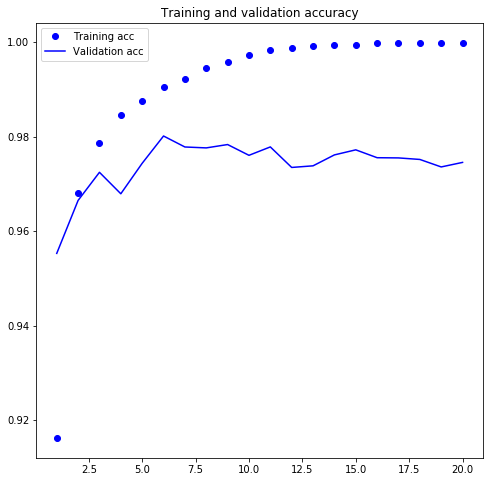

In [21]:
acc = history.history['crf_viterbi_accuracy']
val_acc = history.history['val_crf_viterbi_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize = (8, 8))
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

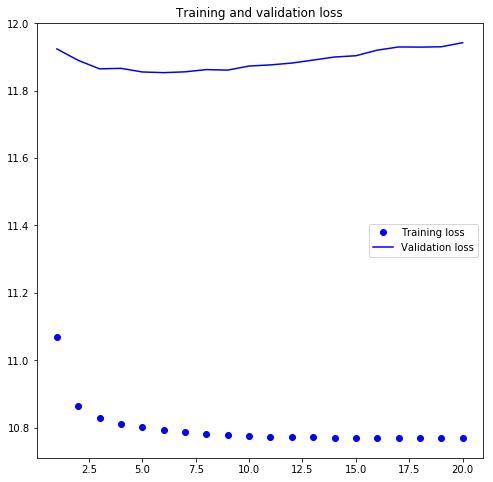

In [22]:
plt.figure(figsize = (8, 8))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [23]:
# Evaluation
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_test_true = np.argmax(y_test, -1)

In [24]:
# Convert the index to tag
y_pred = [[idx2tag[i] for i in row] for row in y_pred]
y_test_true = [[idx2tag[i] for i in row] for row in y_test_true] 

In [25]:
print("F1-score is : {:.1%}".format(f1_score(y_test_true, y_pred)))

F1-score is : 88.0%


In [26]:
report = flat_classification_report(y_pred=y_pred, y_true=y_test_true)
print(report)

              precision    recall  f1-score   support

   B-Disease       0.77      0.78      0.78       190
   I-Disease       0.68      0.58      0.63       165
           O       0.98      0.99      0.99      5397
         PAD       1.00      1.00      1.00     32780

    accuracy                           1.00     38532
   macro avg       0.86      0.84      0.85     38532
weighted avg       1.00      1.00      1.00     38532



In [27]:
tsvfile=open("NCBI-disease-IOB/test.tsv",encoding="utf-8")
tsvreader = csv.reader(tsvfile, delimiter="\t")
data1=[]
sentences1=[]
words1=[]
tags1=[]
for line in tsvreader:
    if line!=[]:
        data1.append(line)
        if line[0] not in words1:
            words1.append(line[0])
        if line[1] not in tags1:
            tags1.append(line[1])
    else:
        sentences1.append(data1)
        data1=[]

X1 = [[word_to_index[w[0] if w[0] in words else "UNK"] for w in s] for s in sentences1]
print(X1[0],X1[1])
count=0
for s in sentences1:
    print(s)
    count=count+1
    if count>5:
        break
# Padding each sequence to have same length  of each word
X1 = pad_sequences(maxlen = max_len, sequences = X1, padding = "post", value = word_to_index["PAD"])
y1 = [[tag_to_index[w[1]] for w in s] for s in sentences1]
print(y1[0])
# padding
y1 = pad_sequences(maxlen = max_len, sequences = y1, padding = "post", value = tag_to_index["PAD"])
num_tag = 3
print(num_tag)
# One hot encoded labels
y1=[to_categorical(i, num_classes = num_tag + 1) for i in y1]

[1, 19, 1, 2672, 7, 17, 6121, 3, 1, 2692, 7, 13, 1, 982, 3, 539, 7400, 22] [1, 3, 1, 30, 123, 3, 982, 32, 150, 13, 1, 2515, 3, 1062, 324, 113, 68, 2672, 7, 17, 1, 2692, 350, 1, 3, 1, 30, 1, 22, 491, 32, 22]
[['Clustering', 'O'], ['of', 'O'], ['missense', 'O'], ['mutations', 'O'], ['in', 'O'], ['the', 'O'], ['ataxia', 'B-Disease'], ['-', 'I-Disease'], ['telangiectasia', 'I-Disease'], ['gene', 'O'], ['in', 'O'], ['a', 'O'], ['sporadic', 'B-Disease'], ['T', 'I-Disease'], ['-', 'I-Disease'], ['cell', 'I-Disease'], ['leukaemia', 'I-Disease'], ['.', 'O']]
[['Ataxia', 'B-Disease'], ['-', 'I-Disease'], ['telangiectasia', 'I-Disease'], ['(', 'O'], ['A', 'B-Disease'], ['-', 'I-Disease'], ['T', 'I-Disease'], [')', 'O'], ['is', 'O'], ['a', 'O'], ['recessive', 'B-Disease'], ['multi', 'I-Disease'], ['-', 'I-Disease'], ['system', 'I-Disease'], ['disorder', 'I-Disease'], ['caused', 'O'], ['by', 'O'], ['mutations', 'O'], ['in', 'O'], ['the', 'O'], ['ATM', 'O'], ['gene', 'O'], ['at', 'O'], ['11q22', 'O'

In [28]:
y_pred = model.predict(X1)
y_pred = np.argmax(y_pred, axis=-1)
y_test_true = np.argmax(y1, -1)

In [29]:
y_pred = [[idx2tag[i] for i in row] for row in y_pred]
y_test_true = [[idx2tag[i] for i in row] for row in y_test_true] 

In [30]:
print("F1-score is : {:.1%}".format(f1_score(y_test_true, y_pred)))

F1-score is : 67.7%


In [31]:
report = flat_classification_report(y_pred=y_pred, y_true=y_test_true)
print(report)

              precision    recall  f1-score   support

   B-Disease       0.48      0.39      0.43       960
   I-Disease       0.54      0.45      0.49      1087
           O       0.95      0.97      0.96     22441
         PAD       1.00      1.00      1.00    134203

    accuracy                           0.99    158691
   macro avg       0.74      0.70      0.72    158691
weighted avg       0.99      0.99      0.99    158691



In [32]:
TP=0
TN=0
FP=0
FN=0
i=0
nument=0
while i<len(y_test_true):
    j=0
    #print(i)
    while j <len(y_test_true[i]):
        #print('j ',j)
        if y_test_true[i][j]=='B-Disease':
            st=j
            nument=nument+1
            j=j+1
            while (y_test_true[i][j]=='I-Disease' or y_test_true[i][j]=='E-Disease') and j<len(y_test_true[i]):
                j=j+1
                #print('inside ',j)
            end=j
            if y_test_true[i][st:end]==y_pred[i][st:end]:
                TP=TP+1
            else:
                FN=FN+1
        elif y_test_true[i][j]=='O' and y_pred[i][j]=='O':
            TN=TN+1
            
        elif y_test_true[i][j]=='O' and y_pred[i][j]!='O':
            FP=FP+1
            
        j=j+1
        
    i=i+1
    
Precision=TP/(TP+FP)
print(Precision)
Recall=TP/(TP+FN)
print(Recall)
F1=(2*Precision*Recall)/(Precision+Recall)
print(F1)
mat=[[TP,FP],[FN,TN]]
print(mat)

0.32954545454545453
0.33403141361256544
0.3317732709308372
[[319, 649], [636, 20845]]


In [33]:
TP=0
TN=0
FP=0
FN=0
i=0
nument=0
while i<len(y_test_true):
    j=0
    #print(i)
    while j <len(y_test_true[i]):
        #print('j ',j)
        if y_test_true[i][j]=='B-Disease':
            st=j
            nument=nument+1
            j=j+1
            while (y_test_true[i][j]=='I-Disease' or y_test_true[i][j]=='E-Disease') and j<len(y_test_true[i]):
                j=j+1
                #print('inside ',j)
            end=j
            found=0
            for k in range(st,end):
                if y_test_true[i][k]==y_pred[i][k]:
                    found=1
                    break
            if found==1:
                TP=TP+1
            else:
                FN=FN+1
            '''if y_test_true[i][st:end]==y_pred[i][st:end]:
                TP=TP+1'''
            
        elif y_test_true[i][j]=='O' and y_pred[i][j]=='O':
            TN=TN+1
            
        elif y_test_true[i][j]=='O' and y_pred[i][j]!='O':
            FP=FP+1
            
        j=j+1
        
    i=i+1
    
Precision=TP/(TP+FP)
print(Precision)
Recall=TP/(TP+FN)
print(Recall)
F1=(2*Precision*Recall)/(Precision+Recall)
print(F1)
mat=[[TP,FP],[FN,TN]]
print(mat)

0.40129151291512916
0.45549738219895286
0.42667974497302597
[[435, 649], [520, 20845]]
